<h1>This notebook:</h1> 
<h2>1. Retrieves from ES the info from jobs_archive about finished analysis jobs using DAODs as inputs, and saves them in panda dataframes for further use for ML studies</h2>
<h2>2. A closer look at the data is taken and a few diagnostic plots are created</h2>

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
import json
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan
from pandas.io.json import json_normalize
from IPython.display import display
from pandas import HDFStore,DataFrame
import pandas as pd

%matplotlib inline 

<h2>Retrieve all job indexes from ES</h2>

In [10]:
es = Elasticsearch(hosts=[{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)

#get job archive indices from ES
indices = es.cat.indices(index="jobs_archive_*", h="index", request_timeout=600).split('\n')
indices = sorted(indices)
indices = [x for x in indices if x != '']
if 'jobs_archive_2016_status' in indices:
    indices.remove('jobs_archive_2016_status')
#remove data due to central problem
#if 'jobs_archive_2016-12-29' in indices:
#    indices.remove('jobs_archive_2016-12-29')
#print(indices)

<h2>Retrieve job archives of interest from ES</h2>

In [11]:
#define function to filter on time
def time_filter(indices, last_days=1, pattern=''):
    if last_days == 0:
        return ["jobs_archive_*"]
    filtered = []
    
    #in case pattern is defined
    if pattern:
        for i in indices:
            if pattern in i:
                filtered.append(i.rstrip())
        return filtered
    
    #otherwise, use last n days
    today = datetime.date.today()
    filtered = []
    datefmt = '%Y-%m-%d'
    for i in indices:
        day = re.sub(r'jobs_archive_', '', i).rstrip() 
        if '_reindexed' in day:
            day = re.sub(r'_reindexed', '', day).lstrip()
        #print(day)
        day = datetime.datetime.strptime(day, datefmt).date()
        diff = today - day
        #print(diff)
        if diff.days < last_days:
            filtered.append(i.rstrip())
    return filtered

In [12]:
#define function to create jobs object from scroll
def jobs_list(scroll, max=-1):
  
    i = 0   
    jobs = []
    
    for result in scroll:
        #print(result['_source']['pandaid'])
        #print_info(result)
        if (max<0):
            jobs.append(result)
        else:
            if (i<max):
                jobs.append(result)
        #if i<1: print_info(result)
        i = i+1
        if not i%100000:  
            print('processing hit '+str(i)+'...')

    return jobs

<h2>Retrieve jobs of interest from ES</h2>

In [13]:
def queryES(es, ind):
    
    #ES query: select finished analysis jobs with inputfile DAOD
    query = "(prodsourcelabel:user) AND (NOT produsername:gangarbt) AND (NOT processingtype:pmerge) AND (jobstatus:finished) AND inputfiletype:DAOD*"
 
    #use scroll to get all hits (allows unlimited result queries)
    scroll = scan(es, index=ind, q=query, scroll='5m', timeout="5m", size=100, _source=[
            "computingsite", "pandaid", "jeditaskid", "inputfileproject","inputfiletype",
            "produsername", "proddblock", "cpuconsumptiontime", "wall_time", "nevents",
            "ninputdatafiles", "inputfilebytes"
        ])

    #jobs = jobs_list(scroll, 10000)
    jobs = jobs_list(scroll)

    #save into Panda Dataframe
    df_orig = json_normalize(jobs)
    #print('Saving into Panda Dataframe') 

    return df_orig  

In [14]:
def get_result(df):
    
    df = df.drop(['_id', '_score', '_type', 'sort'], 1)
    
    #change name and manipulate strings
    df = df.rename(index=str, columns={"_index": "date", "_source.inputfileproject": "scope",
         "_source.inputfiletype":"type", "_source.jeditaskid":"taskid", "_source.pandaid":"pandaid", 
         "_source.proddblock":"scope-name", "_source.computingsite":"site", "_source.produsername":"user",
         "_source.cpuconsumptiontime":"cputime", "_source.wall_time":"walltime", "_source.nevents":"nevents", 
         "_source.ninputdatafiles":"nfiles", "_source.inputfilebytes":"size"})

    #df['date'] = df['date'].str.replace('jobs_archive_', '')
    df['name'] = df['scope-name'].str.split(':').str.get(1)
    df['scope'] = df['scope-name'].str.split(':').str.get(0)#to avoid duplicates (like data16_13TeV and data16_13TeV:data16_13TeV)
    df =  df.drop('scope-name', 1)
    
    #creates new dataframe, with columns with same name untouched, and summing over other columns with different values
    df_new = df.groupby(['name', 'scope']).agg({  
        "pandaid": pd.Series.nunique, "user": pd.Series.nunique, "site": pd.Series.nunique, "taskid": pd.Series.nunique,
        "cputime": pd.Series.sum, "walltime": pd.Series.sum, "nevents": pd.Series.sum, "nfiles": pd.Series.sum,
         "size": pd.Series.sum # sum over unique pandaids, taskids, sites, users. Get the total/day for all the rest  
        }).reset_index()
    
    #check for duplicates
    duplicates = len(df_new[df_new.duplicated('name', keep = False)].name.tolist())
    if duplicates>0:
        print('Error, '+str(duplicates)+' duplicates found')
        display(df_new[df_new.duplicated('name', keep = False)])
    
    return df_new   

In [19]:
#NDAYS=30
NDAYS=''
PATTERN='2017-12-'
#PATTERN=''
ind = time_filter(indices, last_days=NDAYS, pattern=PATTERN) #list of indices per day
STOREWEEKLY = 0
#print(ind)

day = 1
for i in ind:

    print(i)
    df = queryES(es, i)    
    result = get_result(df)
    
    DATE = re.sub(r'jobs_archive_', '', i).rstrip() #save the date
    print(DATE)    
    
    #store to file
    store = HDFStore('DataPopularity_data/store_'+DATE+'.h5')
    store['result'] = result
    store.close()    
    
    if (STOREWEEKLY):
        if (day == 1): #first day of the week
            df_weekly = df
            #print('First df '+str(day))
            FIRSTDAY = DATE
        else:
            df_weekly = pd.concat([df_weekly, df])
            #print('concat df '+str(day))

        if (day == 7): #end of the week
            day = 1 #reset
            #get weekly report
            result_weekly = get_result(df_weekly)
            #store to file
            store_weekly = HDFStore('DataPopularity_data/weekly_'+FIRSTDAY+'.h5')
            store_weekly['result'] = result_weekly
            store_weekly.close()         
        else:
            day += 1

#display(result.head(5))  

jobs_archive_2017-12-01
processing hit 100000...
processing hit 200000...
2017-12-01
jobs_archive_2017-12-02
2017-12-02
jobs_archive_2017-12-03
processing hit 100000...
2017-12-03
jobs_archive_2017-12-04
2017-12-04
jobs_archive_2017-12-05
processing hit 100000...
2017-12-05
jobs_archive_2017-12-06
processing hit 100000...
processing hit 200000...
2017-12-06
jobs_archive_2017-12-07
processing hit 100000...
2017-12-07
jobs_archive_2017-12-08
2017-12-08
jobs_archive_2017-12-09
2017-12-09
jobs_archive_2017-12-10
2017-12-10
jobs_archive_2017-12-11
processing hit 100000...
2017-12-11
jobs_archive_2017-12-12
2017-12-12
jobs_archive_2017-12-13
processing hit 100000...
2017-12-13
jobs_archive_2017-12-14
2017-12-14
jobs_archive_2017-12-15
processing hit 100000...
processing hit 200000...
2017-12-15
jobs_archive_2017-12-16
processing hit 100000...
2017-12-16
jobs_archive_2017-12-17
2017-12-17
jobs_archive_2017-12-18
2017-12-18
jobs_archive_2017-12-19
2017-12-19
jobs_archive_2017-12-20
processing 

,name,scope,taskid,size,site,user,nfiles,pandaid,walltime,cputime,nevents
0,data15_13TeV.00266904.physics_Main.merge.DAOD_...,data15_13TeV,1,36876883,2,1,51,17,5792,489,963
1,data15_13TeV.00266919.physics_Main.deriv.DAOD_...,data15_13TeV,3,6133479,2,1,27,3,406,27,0
2,data15_13TeV.00266919.physics_Main.merge.DAOD_...,data15_13TeV,1,40860892,1,1,32,11,2266,342,1574
3,data15_13TeV.00267073.physics_Main.deriv.DAOD_...,data15_13TeV,3,802528758,1,1,96,3,763,139,0
4,data15_13TeV.00267073.physics_Main.merge.DAOD_...,data15_13TeV,1,90125899,1,1,92,31,23082,834,2584
5,data15_13TeV.00267152.physics_Main.merge.DAOD_...,data15_13TeV,1,142462565,2,1,115,39,9267,968,4478
6,data15_13TeV.00267162.physics_Main.merge.DAOD_...,data15_13TeV,1,240738727,2,1,199,67,23317,2214,7415
7,data15_13TeV.00267167.physics_Main.merge.DAOD_...,data15_13TeV,1,173975491,2,1,100,34,5289,944,5087
8,data15_13TeV.00267358.debugrec_hlt.merge.DAOD_...,data15_13TeV,1,316672,1,1,1,1,231,21,0
9,data15_13TeV.00267359.debugrec_hlt.merge.DAOD_...,data15_13TeV,1,217062,1,1,1,1,216,24,0


[]

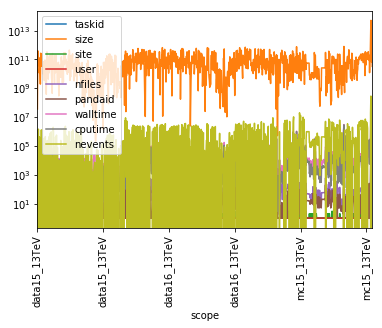

In [21]:
df_test = pd.read_hdf('DataPopularity_data/store_'+DATE+'.h5', 'result')
display(df_test.head(10))

#check for duplicates
display(df_test[df_test.duplicated('name', keep = False)].name.tolist())

#plot
#GD df_test.sort_values('type').plot('type')
df_test.sort_values('scope').plot('scope')
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

<h1>In the second part of the notebook we have a closer look to the data and make some plots</h1>

In [22]:
# use e.g. last_days=7 or pattern='2016-02' (no wildcard !)
NDAYS=30  #NDAYS=150 #NDAYS=''
PATTERN='2017-12' #PATTERN = '2016-03' #PATTERN=''
ind = time_filter(indices, last_days=NDAYS, pattern=PATTERN)
ind = ','.join(ind)
print(ind)

jobs_archive_2017-12-01,jobs_archive_2017-12-02,jobs_archive_2017-12-03,jobs_archive_2017-12-04,jobs_archive_2017-12-05,jobs_archive_2017-12-06,jobs_archive_2017-12-07,jobs_archive_2017-12-08,jobs_archive_2017-12-09,jobs_archive_2017-12-10,jobs_archive_2017-12-11,jobs_archive_2017-12-12,jobs_archive_2017-12-13,jobs_archive_2017-12-14,jobs_archive_2017-12-15,jobs_archive_2017-12-16,jobs_archive_2017-12-17,jobs_archive_2017-12-18,jobs_archive_2017-12-19,jobs_archive_2017-12-20,jobs_archive_2017-12-21,jobs_archive_2017-12-22,jobs_archive_2017-12-23,jobs_archive_2017-12-24,jobs_archive_2017-12-25,jobs_archive_2017-12-26,jobs_archive_2017-12-27,jobs_archive_2017-12-28,jobs_archive_2017-12-29,jobs_archive_2017-12-30,jobs_archive_2017-12-31


<h2>R&D: Retrieve user jobs and convert to DFs</h2>

In [23]:
#select finished analysis jobs with inputfile DAOD
query = "(prodsourcelabel:user) AND (NOT produsername:gangarbt) AND (NOT processingtype:pmerge) AND (jobstatus:finished) AND inputfiletype:DAOD*"

#count hits
#count =(es.count(index=ind, q=query, request_timeout=600))
#print('hits: '+str(count['count']))

#test query with search -> gets only a limited number of records (size=x). Cannot be used for big searches x>10000
#res = es.search(index=ind, q=query, size = 2, request_timeout=600, _source=["computingsite", "pandaid", "jeditaskid", "inputfileproject","inputfiletype","produsername", "proddblock"])
#jobs = res['hits']['hits']
    
#use scroll to get all hits (allows unlimited result queries)
scroll = scan(es, index=ind, q=query, scroll='5m', timeout="5m", size=100, _source=["computingsite", "pandaid", "jeditaskid", "inputfileproject","inputfiletype","produsername", "proddblock"])

#jobs = jobs_list(scroll, 10000)
jobs = jobs_list(scroll)

#save into Panda Dataframe
print('Saving into Panda Dataframe')
df_orig = json_normalize(jobs)
print(df_orig.columns)

processing hit 100000...
processing hit 200000...
processing hit 300000...
processing hit 400000...
processing hit 500000...
processing hit 600000...
processing hit 700000...
processing hit 800000...
processing hit 900000...
processing hit 1000000...
processing hit 1100000...
processing hit 1200000...
processing hit 1300000...
processing hit 1400000...
processing hit 1500000...
processing hit 1600000...
processing hit 1700000...
processing hit 1800000...
processing hit 1900000...
processing hit 2000000...
processing hit 2100000...
processing hit 2200000...
processing hit 2300000...
processing hit 2400000...
processing hit 2500000...
processing hit 2600000...
processing hit 2700000...
processing hit 2800000...
processing hit 2900000...
processing hit 3000000...
processing hit 3100000...
processing hit 3200000...
processing hit 3300000...
processing hit 3400000...
processing hit 3500000...
Saving into Panda Dataframe
Index(['_id', '_index', '_score', '_source.computingsite',
       '_sou

<h2>Re-arrange jobs info in original DF</h2>

In [24]:
#save only interesting columns
df = df_orig[['_index', '_source.inputfileproject', '_source.inputfiletype', '_source.jeditaskid', '_source.pandaid', 
         '_source.proddblock', '_source.computingsite', '_source.produsername']] 

#change name and manipulate strings
df = df.rename(index=str, columns={"_index": "date", "_source.inputfileproject": "scope",
         "_source.inputfiletype":"type", "_source.jeditaskid":"taskid", "_source.pandaid":"pandaid", 
         "_source.proddblock":"name", "_source.computingsite":"site", "_source.produsername":"user"})

df['date'] = df['date'].str.replace('jobs_archive_', '')
df['name'] = df['name'].str.split(':').str.get(1)

#display(df.head(10))
#display(df['date'][0])

#save the date
DATE=df['date'][0]

#DEBUG: number of accesses per dataset per different users
#df_accesses = df.groupby('name')['user'].nunique().reset_index()
#df_accesses.plot('name')
#display(df_accesses.loc[df_accesses['user'] >1])

#type(df)
print("Original re-arranged DF")
display(df.columns)
display(df.shape)

The history saving thread hit an unexpected error (OperationalError('unable to open database file',)).History will not be written to the database.
Original re-arranged DF


Index(['date', 'scope', 'type', 'taskid', 'pandaid', 'name', 'site', 'user'], dtype='object')

(3548621, 8)

<h2>Merge and sum over columns</h2>

,name,date,type,scope,pandaid,site,user
19678,data16_13TeV.00301918.physics_Main.merge.DAOD_...,2017-12-01,DAOD_TOPQ1,data16_13TeV,8,3,4
14909,data16_13TeV.00299147.physics_Main.merge.DAOD_...,2017-12-01,DAOD_TOPQ1,data16_13TeV,10,2,4
21322,data16_13TeV.00302300.physics_Main.merge.DAOD_...,2017-12-01,DAOD_TOPQ1,data16_13TeV,53,6,4
39442,data16_13TeV.00307861.physics_Main.merge.DAOD_...,2017-12-01,DAOD_TOPQ1,data16_13TeV,27,6,4
9819,data15_13TeV.00282712.physics_Main.merge.DAOD_...,2017-12-01,DAOD_TOPQ1,data15_13TeV,16,2,4
5135,data15_13TeV.00279598.physics_Main.merge.DAOD_...,2017-12-01,DAOD_TOPQ1,data15_13TeV,17,1,4
38498,data16_13TeV.00307656.physics_Main.merge.DAOD_...,2017-12-01,DAOD_TOPQ1,data16_13TeV,37,2,4
10995,data15_13TeV.00283780.physics_Main.merge.DAOD_...,2017-12-01,DAOD_TOPQ1,data15_13TeV,46,3,4
43742,data16_13TeV.00310473.physics_Main.merge.DAOD_...,2017-12-01,DAOD_TOPQ1,data16_13TeV,54,3,4
26355,data16_13TeV.00303499.physics_Main.merge.DAOD_...,2017-12-01,DAOD_TOPQ1,data16_13TeV,85,4,4


Sum over pandaid must match original DF


3548621

(93056, 7)

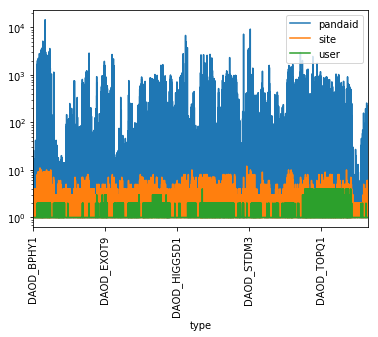

In [25]:
#creates new dataframe, with columns with same name untouched, and summing over other columns with different values
df_new = df.groupby(['name','date', 'type','scope']).agg({
        "pandaid": pd.Series.nunique, "user": pd.Series.nunique, "site": pd.Series.nunique}).reset_index()

display(df_new.sort_values('user',ascending=False).head(10))
print("Sum over pandaid must match original DF")

display(df_new['pandaid'].sum())
display(df_new.shape)

#plot
df_new.sort_values('type').plot('type')
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

<h2>Correlation plots</h2>

In [213]:
def plot2D(df, X_col, Y_col, Z_col):
    Z = df[Z_col]
    Xuniques, X = np.unique(df[X_col], return_inverse=True)
    Yuniques, Y = np.unique(df[Y_col], return_inverse=True)
    
    plt.figure(figsize=(15,5))
    
    plt.scatter(X, Y, c=Z, s=Z)
    # set the limits of the plot to the limits of the data
    plt.colorbar()
    plt.xticks(range(0,len(X)), Xuniques,rotation='vertical')
    plt.yticks(range(0,len(Y)), Yuniques)
    plt.axis([X.min()-1, X.max()+1, Y.min()-0.5, Y.max()+0.5])
    plt.title(str(X_col)+' vs '+str(Y_col)+' vs '+str(Z_col))
    plt.show()
    
    return

,type,scope,user
28,DAOD_HIGG3D1,mc15_13TeV,544
60,DAOD_TOPQ1,data16_13TeV,385
61,DAOD_TOPQ1,mc15_13TeV,238
31,DAOD_HIGG4D2,data16_13TeV,217
1,DAOD_EGAM1,data16_13TeV,183
50,DAOD_SUSY11,data16_13TeV,160
11,DAOD_EXOT12,mc15_13TeV,140
17,DAOD_EXOT4,data16_13TeV,140
59,DAOD_TOPQ1,data15_13TeV,129
0,DAOD_EGAM1,data15_13TeV,118


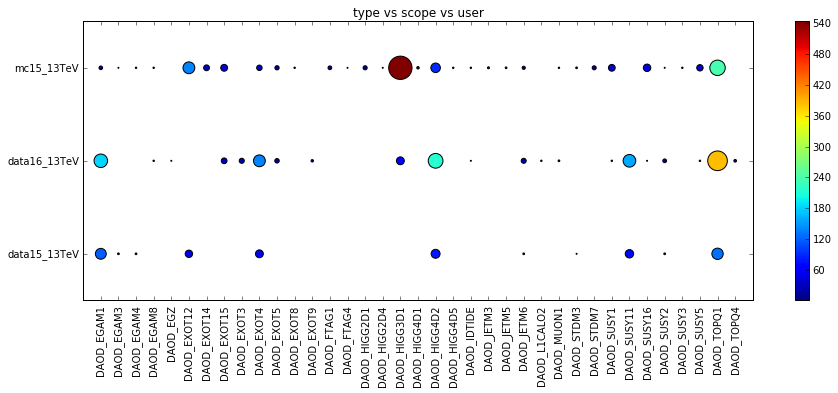

In [214]:
#2D correlation matrix plots scope vs type vs nusers
df_corr = result.groupby(['type', 'scope'])['user'].sum().reset_index()
display(df_corr.sort_values('user',ascending=False).head(10))
plot2D(df_corr, 'type', 'scope','user')

,type,scope,site
28,DAOD_HIGG3D1,mc15_13TeV,674
60,DAOD_TOPQ1,data16_13TeV,446
31,DAOD_HIGG4D2,data16_13TeV,406
50,DAOD_SUSY11,data16_13TeV,291
1,DAOD_EGAM1,data16_13TeV,291
61,DAOD_TOPQ1,mc15_13TeV,258
11,DAOD_EXOT12,mc15_13TeV,159
17,DAOD_EXOT4,data16_13TeV,150
30,DAOD_HIGG4D2,data15_13TeV,142
0,DAOD_EGAM1,data15_13TeV,138


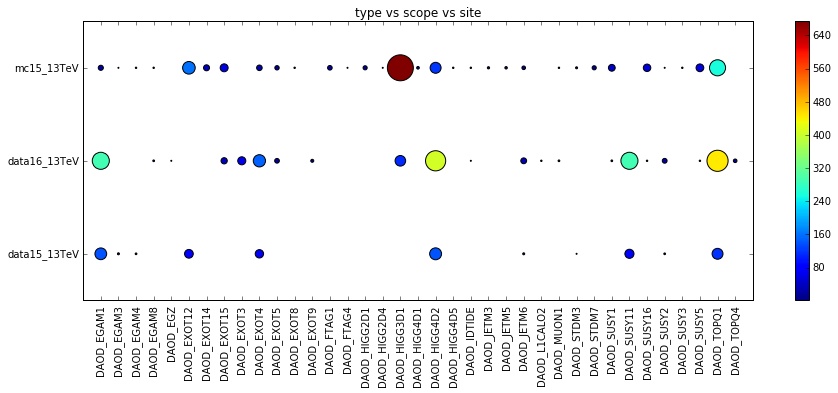

In [215]:
#2D correlation matrix plots scope vs type vs site
df_corr = result.groupby(['type', 'scope'])['site'].sum().reset_index()
display(df_corr.sort_values('site',ascending=False).head(10))
plot2D(df_corr, 'type', 'scope','site')

<h2>DEBUG: Re-arrange datasets as a function of user accesses</h2>

Accesses per unique name and user, summed over pandaid


(3209, 6)

Sum over pandaid must match original DF


108237

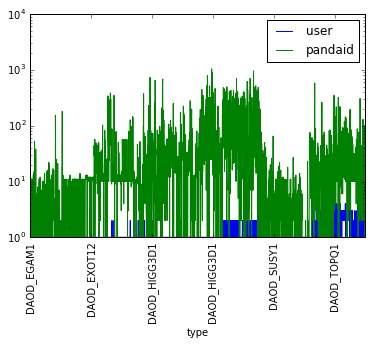

Accesses per unique name (summed over pandaid and users)


(2754, 6)

Sum over pandaid must match original DF


108237

,name,date,type,scope,user,pandaid
1187,data16_13TeV.00307861.physics_Main.merge.DAOD_...,2017-04-28,DAOD_TOPQ1,data16_13TeV,5,221
461,data16_13TeV.00297730.physics_Main.merge.DAOD_...,2017-04-28,DAOD_TOPQ1,data16_13TeV,5,19
1208,data16_13TeV.00308084.physics_Main.merge.DAOD_...,2017-04-28,DAOD_TOPQ1,data16_13TeV,5,188
1410,data16_13TeV.00311402.physics_Main.merge.DAOD_...,2017-04-28,DAOD_TOPQ1,data16_13TeV,4,132
1202,data16_13TeV.00308047.physics_Main.merge.DAOD_...,2017-04-28,DAOD_TOPQ1,data16_13TeV,4,320
1232,data16_13TeV.00309516.physics_Main.merge.DAOD_...,2017-04-28,DAOD_TOPQ1,data16_13TeV,4,308
2723,mc15_13TeV.410501.PowhegPythia8EvtGen_A14_ttba...,2017-04-28,DAOD_TOPQ1,mc15_13TeV,4,263
2722,mc15_13TeV.410501.PowhegPythia8EvtGen_A14_ttba...,2017-04-28,DAOD_TOPQ1,mc15_13TeV,4,258
1136,data16_13TeV.00307454.physics_Main.merge.DAOD_...,2017-04-28,DAOD_TOPQ1,data16_13TeV,4,144
1126,data16_13TeV.00307358.physics_Main.merge.DAOD_...,2017-04-28,DAOD_TOPQ1,data16_13TeV,4,217


In [216]:
#create number of accesses per pandaid -> get rid of site
df_pandaid = df.groupby(['name', 'date', 'type', 'scope', 'user'])['pandaid'].nunique().reset_index()

print("Accesses per unique name and user, summed over pandaid")
display(df_pandaid.shape)
print("Sum over pandaid must match original DF")
display(df_pandaid['pandaid'].sum())
#display(df_pandaid.head(10))

#df_pandaid.plot('user')
#df_pandaid.plot('name')

#create number of accesses per unique user, sum over pandaid
df_user = df_pandaid.groupby(['name','date', 'type','scope']).agg({"pandaid": np.sum, "user": pd.Series.nunique}).reset_index()

#plot it
df_user.sort_values('type').plot('type')
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

# sanity checks
print("Accesses per unique name (summed over pandaid and users)")
display(df_user.shape)
print("Sum over pandaid must match original DF")
display(df_user.pandaid.sum())

#debug
#df_more=df_user.loc[df_user['user'] >1]
#display(df_more)
#df_more['name'][181]
#df_debug=df.loc[df['name']==df_more['name'][181]]
#display(df_debug)

display(df_user.sort_values('user',ascending=False).head(10))

<h2>DEBUG: Re-arrange datasets as a function of accessed replicas</h2>

Accesses per unique name and site, summed over pandaid


(4217, 6)

Sum over pandaid must match original DF


108237

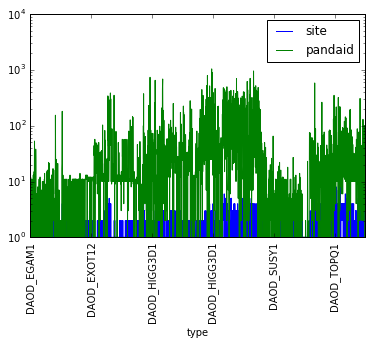

Accesses per unique name (summed over pandaid and sites)


(2754, 6)

Sum over pandaid must match original DF


108237

,name,date,type,scope,site,pandaid
1187,data16_13TeV.00307861.physics_Main.merge.DAOD_...,2017-04-28,DAOD_TOPQ1,data16_13TeV,9,221
2614,mc15_13TeV.410000.PowhegPythiaEvtGen_P2012_ttb...,2017-04-28,DAOD_SUSY5,mc15_13TeV,8,583
1126,data16_13TeV.00307358.physics_Main.merge.DAOD_...,2017-04-28,DAOD_TOPQ1,data16_13TeV,8,217
1176,data16_13TeV.00307716.physics_Main.merge.DAOD_...,2017-04-28,DAOD_TOPQ1,data16_13TeV,8,217
709,data16_13TeV.00301932.physics_Main.merge.DAOD_...,2017-04-28,DAOD_TOPQ1,data16_13TeV,7,95
1202,data16_13TeV.00308047.physics_Main.merge.DAOD_...,2017-04-28,DAOD_TOPQ1,data16_13TeV,7,320
1232,data16_13TeV.00309516.physics_Main.merge.DAOD_...,2017-04-28,DAOD_TOPQ1,data16_13TeV,7,308
1208,data16_13TeV.00308084.physics_Main.merge.DAOD_...,2017-04-28,DAOD_TOPQ1,data16_13TeV,6,188
1338,data16_13TeV.00310809.physics_Main.merge.DAOD_...,2017-04-28,DAOD_TOPQ1,data16_13TeV,6,196
796,data16_13TeV.00302872.physics_Main.merge.DAOD_...,2017-04-28,DAOD_TOPQ1,data16_13TeV,6,89


In [217]:
#create number of accesses per pandaid -> get rid of user
df_pandaid = df.groupby(['name', 'date', 'type', 'scope', 'site'])['pandaid'].nunique().reset_index()

print("Accesses per unique name and site, summed over pandaid")
display(df_pandaid.shape)
print("Sum over pandaid must match original DF")
display(df_pandaid['pandaid'].sum())
#display(df_pandaid.head(10))

#df_pandaid.plot('site')
#df_pandaid.plot('name')

#create number of accesses per unique site, sum over pandaid
df_site = df_pandaid.groupby(['name','date', 'type','scope']).agg({"pandaid": np.sum, "site": pd.Series.nunique}).reset_index()

#plot
df_site.sort_values('type').plot('type')
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

#sanity checks
print("Accesses per unique name (summed over pandaid and sites)")
display(df_site.shape)
print("Sum over pandaid must match original DF")
display(df_site.pandaid.sum())

display(df_site.sort_values('site',ascending=False).head(10))

<h2>DEBUG: Merge dataframes to have number of accessed replicas and number unique_user</h2>

,name,date,type,scope,site,pandaid,user
0,data15_13TeV.00266904.physics_Main.merge.DAOD_...,2017-04-28,DAOD_EGAM1,data15_13TeV,1,1,1
1,data15_13TeV.00266919.physics_Main.merge.DAOD_...,2017-04-28,DAOD_EGAM1,data15_13TeV,1,1,1
2,data15_13TeV.00267073.physics_Main.merge.DAOD_...,2017-04-28,DAOD_EGAM1,data15_13TeV,1,1,1
3,data15_13TeV.00267152.physics_Main.merge.DAOD_...,2017-04-28,DAOD_EGAM1,data15_13TeV,1,1,1
4,data15_13TeV.00267162.physics_Main.merge.DAOD_...,2017-04-28,DAOD_EGAM1,data15_13TeV,2,2,1
5,data15_13TeV.00267167.physics_Main.merge.DAOD_...,2017-04-28,DAOD_EGAM1,data15_13TeV,1,1,1
6,data15_13TeV.00267638.physics_Main.merge.DAOD_...,2017-04-28,DAOD_EGAM1,data15_13TeV,1,2,1
7,data15_13TeV.00267639.debugrec_hlt.merge.DAOD_...,2017-04-28,DAOD_SUSY11,data15_13TeV,1,1,1
8,data15_13TeV.00267639.physics_Main.merge.DAOD_...,2017-04-28,DAOD_EGAM1,data15_13TeV,2,2,1
9,data15_13TeV.00270441.physics_Main.merge.DAOD_...,2017-04-28,DAOD_EGAM1,data15_13TeV,1,1,1


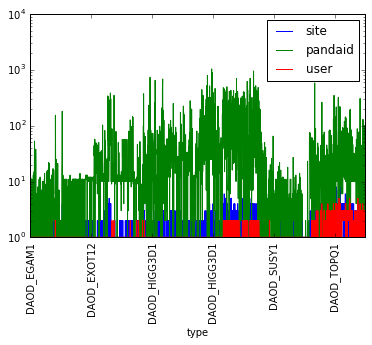

In [218]:
#merge the two dataframes
result = pd.merge(df_site, df_user, how='inner', on=['name','date','type','scope','pandaid'])
display(result.head(10))

#plot
result.sort_values('type').plot('type')
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()